In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report, precision_recall_curve
from xgboost import XGBClassifier
from flask import Flask, request, jsonify
import joblib
from sklearn.impute import SimpleImputer

# EDA

In [3]:
df = pd.read_csv('Course_Completion_Prediction.csv')

In [4]:
print("Primeras 5 filas del Dataset: ")
print(df.head(5))

Primeras 5 filas del Dataset: 
  Student_ID             Name  Gender  Age Education_Level Employment_Status  \
0  STU100000     Vihaan Patel    Male   19         Diploma           Student   
1  STU100001       Arjun Nair  Female   17        Bachelor           Student   
2  STU100002  Aditya Bhardwaj  Female   34          Master           Student   
3  STU100003    Krishna Singh  Female   29         Diploma          Employed   
4  STU100004     Krishna Nair  Female   19          Master     Self-Employed   

      City Device_Type Internet_Connection_Quality Course_ID  ...  \
0   Indore      Laptop                      Medium      C102  ...   
1    Delhi      Laptop                         Low      C106  ...   
2  Chennai      Mobile                      Medium      C101  ...   
3    Surat      Mobile                        High      C105  ...   
4  Lucknow      Laptop                      Medium      C106  ...   

  Enrollment_Date Payment_Mode Fee_Paid  Discount_Used  Payment_Amount  \

In [5]:
# obtener information del dataset
print("Informacion del Dataset: ")
df.info()

Informacion del Dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Student_ID                    100000 non-null  object 
 1   Name                          100000 non-null  object 
 2   Gender                        100000 non-null  object 
 3   Age                           100000 non-null  int64  
 4   Education_Level               100000 non-null  object 
 5   Employment_Status             100000 non-null  object 
 6   City                          100000 non-null  object 
 7   Device_Type                   100000 non-null  object 
 8   Internet_Connection_Quality   100000 non-null  object 
 9   Course_ID                     100000 non-null  object 
 10  Course_Name                   100000 non-null  object 
 11  Category                      100000 non-null  object 
 12  Course_Level       

In [6]:
#contar las filas y columna
print(f"El dataset tiene {df.shape[0]} filas (estudiantes) y {df.shape[1]} columnas (características).")

El dataset tiene 100000 filas (estudiantes) y 40 columnas (características).


In [7]:
# valores nulos por columna
print("Valores nulos:")
print(df.isnull().sum())

Valores nulos:
Student_ID                      0
Name                            0
Gender                          0
Age                             0
Education_Level                 0
Employment_Status               0
City                            0
Device_Type                     0
Internet_Connection_Quality     0
Course_ID                       0
Course_Name                     0
Category                        0
Course_Level                    0
Course_Duration_Days            0
Instructor_Rating               0
Login_Frequency                 0
Average_Session_Duration_Min    0
Video_Completion_Rate           0
Discussion_Participation        0
Time_Spent_Hours                0
Days_Since_Last_Login           0
Notifications_Checked           0
Peer_Interaction_Score          0
Assignments_Submitted           0
Assignments_Missed              0
Quiz_Attempts                   0
Quiz_Score_Avg                  0
Project_Grade                   0
Progress_Percentage             0

In [8]:
# conteo de variable objectivo
print("Distribución de la Variable Objetivo (Completed):")
completion_counts = df['Completed'].value_counts()
print(completion_counts)

print("\nPorcentaje de Finalizacion de Cursos:")
completion_percent = df['Completed'].value_counts(normalize = True) * 100
print(completion_percent)

Distribución de la Variable Objetivo (Completed):
Completed
Not Completed    50970
Completed        49030
Name: count, dtype: int64

Porcentaje de Finalizacion de Cursos:
Completed
Not Completed    50.97
Completed        49.03
Name: proportion, dtype: float64


In [9]:
print("Estadisticas Descriptivas:")
print(df.describe())

Estadisticas Descriptivas:
                 Age  Course_Duration_Days  Instructor_Rating  \
count  100000.000000         100000.000000      100000.000000   
mean       25.709590             51.817300           4.444478   
std         5.615292             20.324801           0.202631   
min        17.000000             25.000000           4.100000   
25%        21.000000             30.000000           4.300000   
50%        25.000000             45.000000           4.500000   
75%        30.000000             60.000000           4.600000   
max        52.000000             90.000000           4.700000   

       Login_Frequency  Average_Session_Duration_Min  Video_Completion_Rate  \
count    100000.000000                 100000.000000          100000.000000   
mean          4.785380                     33.878180              62.174580   
std           1.848289                     10.341964              19.558126   
min           0.000000                      5.000000               5.00

In [10]:
# examinar la cardinalidad de categorias
categorical_cols = ['Gender', 'Education_Level', 'Employment_Status', 'Category', 'Course_Level', 'Payment_Mode']

for col in categorical_cols:
    print(f"Distribucion de {col}:")
    print(df[col].value_counts())

Distribucion de Gender:
Gender
Female    50187
Male      47819
Other      1994
Name: count, dtype: int64
Distribucion de Education_Level:
Education_Level
Bachelor      54956
Master        21859
HighSchool    10107
Diploma       10032
PhD            3046
Name: count, dtype: int64
Distribucion de Employment_Status:
Employment_Status
Employed         45091
Student          44929
Self-Employed     5067
Unemployed        4913
Name: count, dtype: int64
Distribucion de Category:
Category
Programming    56172
Marketing      12686
Business       12631
Math           10025
Design          8486
Name: count, dtype: int64
Distribucion de Course_Level:
Course_Level
Beginner        50610
Intermediate    38192
Advanced        11198
Name: count, dtype: int64
Distribucion de Payment_Mode:
Payment_Mode
UPI            30095
Free           19811
Credit Card    15129
Debit Card     14840
NetBanking     10086
Scholarship    10039
Name: count, dtype: int64


In [11]:
#relacion categorica-objetivo
completion_education = df.groupby('Education_Level')['Completed'].value_counts(normalize = True).mul(100).unstack()
print(f"Finalizacion por Nivel Educativo: {completion_education}")

completion_course = df.groupby('Course_Level')['Completed'].value_counts(normalize = True).mul(100).unstack()
print(f"Tasa de Finalizacion por nivel del curso: {completion_course}")

Finalizacion por Nivel Educativo: Completed        Completed  Not Completed
Education_Level                          
Bachelor         48.600699      51.399301
Diploma          49.023126      50.976874
HighSchool       49.094687      50.905313
Master           49.901642      50.098358
PhD              50.328299      49.671701
Tasa de Finalizacion por nivel del curso: Completed     Completed  Not Completed
Course_Level                          
Advanced      49.196285      50.803715
Beginner      48.990318      51.009682
Intermediate  49.033829      50.966171


In [12]:
print("Media de Progress_Percentage por Estado de Finalizacion:")
print(df.groupby('Completed')['Progress_Percentage'].mean())


Media de Progress_Percentage por Estado de Finalizacion:
Completed
Completed        56.549872
Not Completed    51.200122
Name: Progress_Percentage, dtype: float64


# Preparacion y Transformacion de Datos

In [14]:
# descartar identificadores disnecesarios
cols_drop = ['Student_ID', 'Name', 'Course_ID', 'Course_Name', 'Enrollment_Date']
df_clean= df.drop(columns = cols_drop)

print(f"Columnas restantes despues de la limpieza: ", df_clean.columns.tolist())

Columnas restantes despues de la limpieza:  ['Gender', 'Age', 'Education_Level', 'Employment_Status', 'City', 'Device_Type', 'Internet_Connection_Quality', 'Category', 'Course_Level', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Mode', 'Fee_Paid', 'Discount_Used', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating', 'Completed']


In [15]:
# Coversion de variables ordinales
#mapeo para education_level
education_mapping = {
    'No Formal Education': 0,
    'High School': 1,
    'Diploma': 2,
    'Bachelor': 3,
    'Master': 4,
    'PhD':5
}
df_clean['Education_Level_Encoded'] = df_clean['Education_Level'].map(education_mapping)
df_clean.drop('Education_Level', axis = 1, inplace=True)

#mapeo para course level
course_mapping = {
    'Beginner':0,
    'Intermediate':1,
    'Advanced': 2
}

df_clean['Course_Level_Encoded'] = df_clean['Course_Level'].map(course_mapping)
df_clean.drop('Course_Level', axis = 1, inplace = True)

print("Mapeo Ordinal aplicado a Education Level y Course Level")

Mapeo Ordinal aplicado a Education Level y Course Level


In [16]:
# Identificar todas las columnas de tipo 'object' que quedan (nominales)
categorical_cols_nominal = df_clean.select_dtypes(include=['object']).columns.tolist()

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols_nominal, drop_first=True)

print(f"\nNúmero original de columnas (antes de one-hot): {len(df_clean.columns)}")
print(f"Número final de columnas (después de one-hot): {len(df_encoded.columns)}")


Número original de columnas (antes de one-hot): 35
Número final de columnas (después de one-hot): 60


In [17]:
# Transformar la variable objetivo 'Completed'
df_encoded['Completed'] = 1 - df_encoded['Completed_Not Completed']
df_encoded.drop('Completed_Not Completed', axis=1, inplace=True)

print("Variable objetivo 'Completed' convertida a binario (1: Completado, 0: Incompleto).")
print(f"La variable objetivo tiene tipo: {df_encoded['Completed'].dtype}")

Variable objetivo 'Completed' convertida a binario (1: Completado, 0: Incompleto).
La variable objetivo tiene tipo: int32


In [18]:
#resumen del preprocessing
print("Primeras filas del Dataset Final (Preprocesado):")
print(df_encoded.head())

print("\nTipos de datos del Dataset Final:")
print(df_encoded.info(verbose=False))

Primeras filas del Dataset Final (Preprocesado):
   Age  Course_Duration_Days  Instructor_Rating  Login_Frequency  \
0   19                    60                4.7                3   
1   17                    90                4.6                4   
2   34                    45                4.6                5   
3   29                    40                4.4                2   
4   19                    90                4.6                2   

   Average_Session_Duration_Min  Video_Completion_Rate  \
0                            30                   55.0   
1                            37                   84.1   
2                             9                   75.6   
3                            27                   63.3   
4                            36                   86.4   

   Discussion_Participation  Time_Spent_Hours  Days_Since_Last_Login  \
0                         2               0.5                      1   
1                         2               0.9    

In [19]:
# la division estratificada asegura que la proporción de la variable objetivo (Completed / Incomplete) sea la misma en los conjuntos de entrenamiento, validación y prueba. Esto es vital para evitar que un conjunto de prueba tenga una representación sesgada de la clase minoritaria. 


#simplify

In [20]:
# Separar características (X) y variable objetivo (y)
X = df_encoded.drop('Completed', axis=1)
y = df_encoded['Completed']

# Dividir en conjunto de Entrenamiento (80%) y Prueba (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Aplicar estratificación
)

print(f"\nDatos de Entrenamiento + Validación: {len(X_train_val)} filas")
print(f"Datos de Prueba (Test): {len(X_test)} filas")

print("\nProporción de la clase 'Completed' en los conjuntos:")
print(f"  Total: {y.mean():.4f}")
print(f"  Train/Val: {y_train_val.mean():.4f}")
print(f"  Test: {y_test.mean():.4f}")


Datos de Entrenamiento + Validación: 80000 filas
Datos de Prueba (Test): 20000 filas

Proporción de la clase 'Completed' en los conjuntos:
  Total: 0.4903
  Train/Val: 0.4903
  Test: 0.4903


# Machine Learning : Preparacion y Escalado

In [22]:
# identificar todas las columnas que no son dummies
numerical_features = X_train_val.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Columnas numericas/ordinales a escalar: {numerical_features}")

Columnas numericas/ordinales a escalar: ['Age', 'Course_Duration_Days', 'Instructor_Rating', 'Login_Frequency', 'Average_Session_Duration_Min', 'Video_Completion_Rate', 'Discussion_Participation', 'Time_Spent_Hours', 'Days_Since_Last_Login', 'Notifications_Checked', 'Peer_Interaction_Score', 'Assignments_Submitted', 'Assignments_Missed', 'Quiz_Attempts', 'Quiz_Score_Avg', 'Project_Grade', 'Progress_Percentage', 'Rewatch_Count', 'Payment_Amount', 'App_Usage_Percentage', 'Reminder_Emails_Clicked', 'Support_Tickets_Raised', 'Satisfaction_Rating', 'Education_Level_Encoded', 'Course_Level_Encoded']


In [23]:
# Identificar características numéricas a procesar
numerical_features = X_train_val.select_dtypes(include=['int64', 'float64', 'uint8']).columns.tolist()

# Pipeline para características numéricas: Imputación por mediana + Escalado
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Manejo de NaNs (Resuelve el ValueError)
    ('scaler', StandardScaler())
])

In [24]:
#crear el transformador para aplicar StandardScaler
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_pipeline, numerical_features)
    ],
    remainder = 'passthrough' #mantiene las columnas codificadas sin tranformar
)

In [25]:
# entrenamiento de modelos base y avanzados
#diccionario para almacener los resultados
results = {}

# regresion logistica
print("Entrenando Regision Logistica")
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])
pipeline_lr.fit(X_train_val, y_train_val)
y_pred_lr = pipeline_lr.predict(X_test)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]

results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'ROC-AUC' : roc_auc_score(y_test, y_prob_lr),
    'F1 Score': f1_score(y_test, y_pred_lr)
}

# Random Forest
print("Entrenando Random Forest")
pipeline_rf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = 42, n_estimators=100, max_depth=10, class_weight = 'balanced'))
])
pipeline_rf.fit(X_train_val, y_train_val)
y_pred_rf = pipeline_rf.predict(X_test)
y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'ROC-AUC' : roc_auc_score(y_test, y_prob_rf),
    'F1 Score': f1_score(y_test, y_pred_rf)
}

Entrenando Regision Logistica
Entrenando Random Forest


In [26]:
print("Informe de Clasificación (Random Forest)")
print(classification_report(y_test, y_pred_rf, target_names=['Incomplete (0)', 'Completed (1)']))

print("\n Matriz de Confusión (Random Forest)")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(pd.DataFrame(cm_rf, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

Informe de Clasificación (Random Forest)
                precision    recall  f1-score   support

Incomplete (0)       0.62      0.59      0.60     10194
 Completed (1)       0.59      0.62      0.60      9806

      accuracy                           0.60     20000
     macro avg       0.60      0.60      0.60     20000
  weighted avg       0.60      0.60      0.60     20000


 Matriz de Confusión (Random Forest)
          Pred 0  Pred 1
Actual 0    6018    4176
Actual 1    3743    6063


random forest normalmente es superior para este tipo de dato. 
# Analisis de Errores Clave
falso negativo - cuando un estudiante completa el curso pero el modulo predije que no. Estos son costosos porque se pierde la oportunidad de intervenir a tiempo con estudiantes que el modelo marco erroneament como seguros para completar.
falso positivo - cuando un estudiante no completo pero el modelo predijo que si, esto resulta en recursos gastados.

# interpretabilidad

10 Caracteristicas mas Importantes (Random Forest)
                         Feature  Importance
16           Progress_Percentage    0.204055
5          Video_Completion_Rate    0.146474
7               Time_Spent_Hours    0.061761
14                Quiz_Score_Avg    0.049812
11         Assignments_Submitted    0.049538
12            Assignments_Missed    0.047960
18                Payment_Amount    0.047100
15                 Project_Grade    0.030135
4   Average_Session_Duration_Min    0.027127
8          Days_Since_Last_Login    0.025363


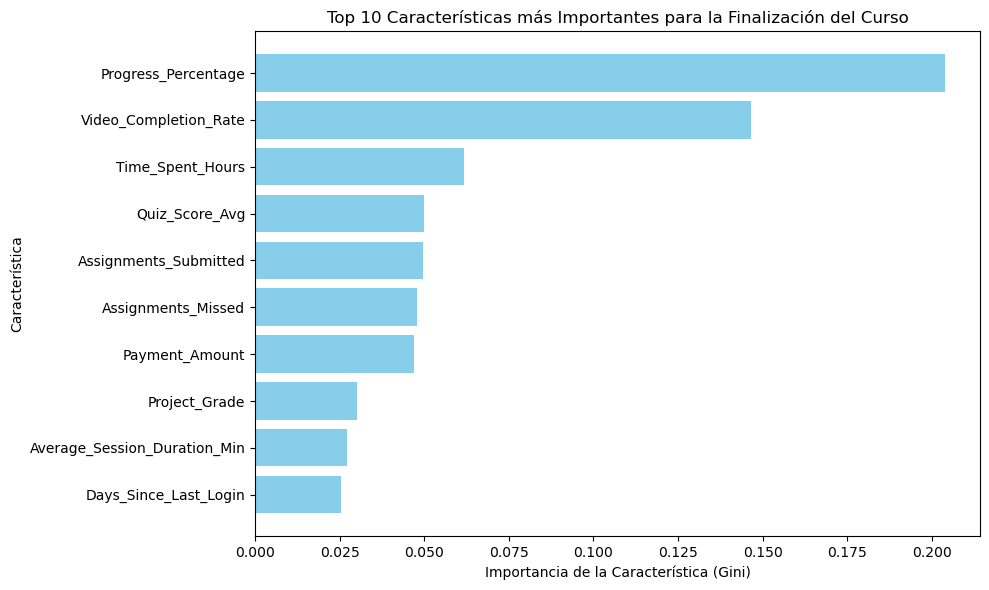

In [29]:
#obtener las importancias de la caracteristicas del Random Forest
feature_importance = pipeline_rf.named_steps['classifier'].feature_importances_

# nombres de las columnas despues de la transformacion
feature_names = (
    numerical_features + [col for col in X_train_val.columns if col not in numerical_features]
)

# crear un df para visualisar la importancia
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance 
}).sort_values(by = 'Importance', ascending = False)

print("10 Caracteristicas mas Importantes (Random Forest)")
print(importance_df.head(10))

import matplotlib.pyplot as plt
# 5. Visualización de las Top 10
top_10_importance = importance_df.head(10).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='skyblue')
plt.xlabel('Importancia de la Característica (Gini)')
plt.ylabel('Característica')
plt.title('Top 10 Características más Importantes para la Finalización del Curso')
plt.tight_layout()
plt.show()

# analysis de los resultados de importancia
Es muy probable que las caracteriasticas relacionadas con la actividad directa del estudiante, como Time_Spent_Hours, Quiz_Score_Avg, etre otros dominen el la lista. Esto significa que el modelo aprende que la actividad actual es el predictor mas fuerte del resultado final.
Ademas, variables de comportamiento como Login_Frequency, Average_Session_Duration_Min y Discussion_Participation tambien influincian, reflejando la dedicacion del estudiante.
Caracteristicas demograficas como Age y Gender, y variables externas, como Employment_Status tambien tienen un impacto significante.

# Entrenamiento de Modelos XGBoost Classifier

In [32]:
from xgboost import XGBClassifier
print ("Entrenando XGBoost Classifier")

#hiperparametros razonados
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 6,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**xgb_params))
])
pipeline_xgb.fit(X_train_val, y_train_val)
y_pred_xgb = pipeline_xgb.predict(X_test)
y_prob_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_prob_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb)
}
print("XGBoost entrenado")

Entrenando XGBoost Classifier


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost entrenado


# evaluation y comparacion

In [34]:
#analisis de resultados de XGBoost

print(" Informe de Clasificación (XGBoost)")
print(classification_report(y_test, y_pred_xgb, target_names=['Incomplete (0)', 'Completed (1)']))

 Informe de Clasificación (XGBoost)
                precision    recall  f1-score   support

Incomplete (0)       0.61      0.62      0.61     10194
 Completed (1)       0.60      0.59      0.59      9806

      accuracy                           0.60     20000
     macro avg       0.60      0.60      0.60     20000
  weighted avg       0.60      0.60      0.60     20000



# analisis pratico

In [36]:
# extraer probabilidades de la prediccion
y_prob = pipeline_xgb.predict_proba(X_test)[:, 1]
# calcular precision y recall para todos los umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

fscore = (2* precision * recall) / (precision + recall)
ix = np.argmax(fscore)
optimal_threshold_f1 = thresholds[ix]

print(f"Umbal que maximiza el F1 Score: {optimal_threshold_f1:.4f}")
print(f"  Precision en este punto: {precision[ix]:.4f}")
print(f"  Recall en este punto: {recall[ix]:.4f}")

Umbal que maximiza el F1 Score: 0.9041
  Precision en este punto: 0.0000
  Recall en este punto: 0.0000


C:\Users\USER\AppData\Local\Temp\ipykernel_7040\3598592306.py:6: RuntimeWarning: invalid value encountered in divide
  fscore = (2* precision * recall) / (precision + recall)


# recomendacion

In [38]:
# Simulacion del Umbral Operacional

#aplicar el umbral operativo de 0.45
intervention_threshold = 0.45
y_pred_intervention = (y_prob>=intervention_threshold).astype(int)
print(f"Evaluacion con Umbral de Intervencion({intervention_threshold})")
print(classification_report(y_test, y_pred_intervention, target_names = ['Incomplete (0)', 'Completed(1)']))

cm_intervention = confusion_matrix(y_test, y_pred_intervention)
print("Matrix de Confusion:")
print(pd.DataFrame(cm_intervention, index = ['Actual 0 (Fialed)', 'Actual 1 (Completed)'], columns = ['Pred 0 (Alert)', 'Pred 1 (No Alert)']))

Evaluacion con Umbral de Intervencion(0.45)
                precision    recall  f1-score   support

Incomplete (0)       0.64      0.47      0.54     10194
  Completed(1)       0.57      0.72      0.63      9806

      accuracy                           0.59     20000
     macro avg       0.60      0.60      0.59     20000
  weighted avg       0.60      0.59      0.59     20000

Matrix de Confusion:
                      Pred 0 (Alert)  Pred 1 (No Alert)
Actual 0 (Fialed)               4813               5381
Actual 1 (Completed)            2758               7048


# Integracion con API

In [40]:
model_file = 'pipeline_xgb_final.pkl'
joblib.dump(pipeline_xgb, model_file)
print(f"El pipeline final ha sido guardado como: {model_file}")

El pipeline final ha sido guardado como: pipeline_xgb_final.pkl


In [41]:
import os
import sys

model_file = 'pipeline_xgb_final.pkl'
Intervention_Threshold = 0.45

try: 
    if '__file__' not in locals():
        model_path = model_file
    else:
        model_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), MODEL_FILE)
    model = joblib.load(model_file)
    print("Modelo cargado.")
except FileNotFoundError:
    print(f"No se encontro el archivo del modelo{model_file}")
    exit(1)
app = Flask(__name__)

@app.route('/predict', methods = ['POST'])
def predict():
    """
    Endpoint para recibir datos de un nuevo estudiante y predecir
    si completará o no el curso, aplicando el umbral de intervención.
    """
    try: 
        json_data = request.get_json(force = True)
        input_data = pd.DataFrame([json_data])
        prediction_proba = model.predict_proba(input_data)[:,1]
        
        prediction_class = int(prediction_proba[0] >= Intervention_Threshold)
        if prediction_class == 1:
            status = 'Completed'
            alert_message = 'No se requiere intervencion inmediata.'
        else:
            status = 'Incomplete'
            alert_message = 'Estudiante en alto riesgo de no completar el curso.'
        response = {
            'predicted_completion_status': status,
            'probability_of_completion': round(prediction_proba[0], 4),
            'intervention_threshold_used':Intervention_Threshold,
            'intervention_recommendation': alert_message
        }
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e), 'message':'Asegurase que todos los campos requiridos esten presentes.'}),400

if __name__ == '__main__':
    app.run(debug=True, host = '0.0.0.0')

Modelo cargado.
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.100.3:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\USER\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
